# Explainer notebook

## Motivation
The data used for this project consists of wikipedia pages for all artists from the lists of [West Coast Hip Hop](https://en.wikipedia.org/wiki/List_of_West_Coast_hip_hop_artists) artists and [Dance Pop](https://en.wikipedia.org/wiki/List_of_dance-pop_artists) artists.
Furthermore, [Genius](https://genius.com) has been scraped to obtain song lyrics for each artist. The number of artists in each genre is approximately the same, which enables us to generate
a network without having to worry about problems caused by differences in amount of data. In addition, these two genres are expected to have somewhat of an overlap, while still being
distinct enough to form clear clusters in a network. 

Another reason behind our choice of data is practicality. The wikipedia pages are easily downloaded, and can be directly interpreted as a network, where the pages are nodes and the 
links between pages are edges. This construction lends itself well to graph analysis. We decided to use song lyrics as our secondary dataset, as these include word
usage over time, allowing for some interesting sentiment analysis. 

We aimed to make relatively complex data analysis more digestible, by using relatable data that most people have knowledge of. This is also reflected in the simplicity of our [website](https://nadjariis.github.io/SocialGraphs2020/),
which should ideally be comprehensible for all interested readers. The following sections in this notebook will further explain the process of preparing the data, as well as the 
various tools and methods of analysis that we have applied to the data.

## Data Preparation and Basic Stats

### Downloading wikipedia pages
The majority of the work here lies in scraping the lists of West Coast Hip Hop and Dance Pop artists, such that we get only the names of the artists from those two lists. 
Once we have two nice lists containing only the artists, downloading the actual text from all the wikipedia pages is relatively straightforward.

We start out by simply making a list of all links found on each of the two wikipedia lists. This will however create a few issues with the Dance Pop artists, as the list containing
those artists has a whole bunch of references at the bottom of the page. These will also be interpreted as links by our regular expression. As a result of this, we ended up manually creating
a list of all Dance Pop artists (called `DancePop_artists.txt`), and simply using this list to determine the links to the wikipedia pages of those artists.



In [107]:
# First, some imports
import pandas as pd
import re
import urllib.request
import json
import ftfy
import os

from wordcloud import WordCloud

In [ ]:
# Define urls
url_west_coast = "https://en.wikipedia.org/wiki/List_of_West_Coast_hip_hop_artists"
url_dance_pop = "https://en.wikipedia.org/wiki/List_of_dance-pop_artists"

In [ ]:
# Function to create lists of links to the wikipedia pages 
# input: url to scrape for links and name of the page to scrape

def link_list(url, sitename): 

    # for creating query
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    title = "titles="+ sitename
    content = "prop=revisions&rvprop=content"
    dataformat ="format=json"

    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)

    # get text from wikipedia page
    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')

    # find all links in text
    linklist  = re.findall("\[\[(.*?)\]\]", wikitext)
    
    return linklist

In [ ]:
# Create lists containing all links from the two websites
links_west_coast = link_list(url_west_coast, "List_of_West_Coast_hip_hop_artists")
links_dance_pop = link_list(url_dance_pop, "List_of_dance-pop_artists")

# Get all the actual Dance Pop artists from manually created file
dance_pop_artists =  open("./DancePop_artists.txt","r").read().split('\n')

In [ ]:
# Remove none artist links from links_west_coast
links_west_coast = links_west_coast[1:-3] 

# Use DancePop_artists file to clean links_dance_pop, such that it only contains links to artists
clean_links_dance_pop = [] 
for artist in links_dance_pop:
    artist_clean = ftfy.fixes.decode_escapes(artist)
    artist_clean_split = artist_clean.split('|')

    if len(artist_clean_split) > 1:
        if artist_clean_split[1] in dance_pop_artists:
            clean_links_dance_pop.append(artist_clean)

    elif len(artist_clean_split) == 1:
        if artist_clean_split[0] in dance_pop_artists:
            clean_links_dance_pop.append(artist_clean)

# links_dance_pop will now only contain links to artists
links_dance_pop = clean_links_dance_pop

Since we now have two lists containing only links to artists from the two genres, we choose to create a dataframe containing the name of the artist, the wikipedia link name
and the genre of the artist. 

In [ ]:
# Create dataframe containing artist name, wikilink and genre
def create_dataframe(linklist, genre): 
    artistname = []
    wikilink = []
    genres = []

    for artist in linklist: 
        if '|' in artist: 
            artist_split = artist.split('|')
            artistname.append(artist_split[1])
            wikilink.append(artist_split[0].replace(' ', '_'))
            genres.append(str(genre))
        else: 
            artistname.append(artist)
            wikilink.append(artist.replace(' ', '_'))
            genres.append(str(genre))

    df = pd.DataFrame(list(zip(artistname, wikilink, genres)), columns =['Artist', 'WikiLink', 'Genre']) 

    return df 

In [ ]:
# Create two dataframes
west_coast_df = create_dataframe(links_west_coast, 'West Coast')
dance_pop_df = create_dataframe(links_dance_pop, 'Dance Pop')

In [ ]:
# Fix a few errors manually and save dataframes to csv
dance_pop_df.loc[37].Artist = 'Black Eyed Peas'
dance_pop_df.loc[37].WikiLink = 'Black_Eyed_Peas'
west_coast_df = west_coast_df.drop(1) # remove "11/5"

west_coast_df.to_csv('west_coast_df.csv', index=False)
dance_pop_df.to_csv('dance_pop_df.csv', index=False)

Finally, we are ready to download the actual text from each wikipedia page to use for further analysis. We simply save the content of each wikipedia page as a .txt file with
the name being the wikipedia link to the artist (e.g. `Bad_Boys_Blue.txt` for artist Bad Boys Blue). 

In [ ]:
# Function to retrieve content of wikipedia pages
# input: dataframe containing links to pages, and path where file should be saved

def get_wikitext(df, path): 
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    content = "prop=revisions&rvprop=content"
    dataformat ="format=json"
    redirects = "redirects"
    
    for link in df['WikiLink']:
        try: 
            title = link
            query = "{}{}&{}&titles={}&{}&{}".format(baseurl, action, content, title, dataformat, redirects)
            
            # fix utf8
            query = query.replace("é", "%C3%A9")
            query = query.replace("á","%C3%A1")
            query = query.replace("í","%C3%AD")
            query = query.replace("ë","%C3%AB")
            query = query.replace("ä","%C3%A4")
            query = query.replace("ó","%C3%B3")
            query = query.replace("Á","%C3%81")

            wikiresponse = urllib.request.urlopen(query)
            wikidata = wikiresponse.read()
            wikitext = wikidata.decode('utf-8')

            with open(path + link + '.txt', 'w') as outfile:
                json.dump(wikitext, outfile)
        except: 
            print('Could not find ' + link)

In [ ]:
# Use function to extract wikipages for artist 
path = '/home/jovyan/work/wikipages_west_coast/'
get_wikitext(west_coast_df, path)

path = '/home/jovyan/work/wikipages_dance_pop/'
get_wikitext(dance_pop_df, path)

### Downloading song lyrics

In the analysis we want to use two different approache to text analysis, one analyzing network of links between
wikipages and another analyzing the words and sentiment of each artist song lyrics. 

Therefore we needed to download the songs for each artist from the Dance Pop and West Coast genre. 
For this purpose we used the genius API. Genius is a website which host artist names and their 
corresponding song lyrics. First of using the genius API we collect the artist id based on their each 
artists name. The functions used to retrieve songs ids, song lyrics and just the genreal setup is based upon 
[Chris](https://github.com/ANOVAProjectUSYD/lyrics-analysis) with some additions and modification to fit
our needs.    



In [128]:
# Requirements
!pip install bs4==0.0.1
!pip install pandarallel

In [ ]:
import numpy as np
import requests
import urllib.parse

from bs4 import BeautifulSoup
from pandarallel import pandarallel

In [ ]:
# Constants
base = "https://api.genius.com"
client_access_token = "-q1tRGBZMEOk6JewZCC_KWZBxyFSg9nccGlX11Cb3MxpGpzWG4FBSJIXCJS33D3x"

Fetching the artist id from the html of each artist page on genius. The artist id is always after the following 
text in the html file '/genius/artists/', therefore we extracted the id between the line and a newline.     

In [ ]:
def get_artist_id(artist_name):
    url = "https://genius.com/artists/"
    req = urllib.request.Request(url+artist_name, headers={'User-Agent': 'Mozilla/5.0'})
    html = urllib.request.urlopen(req).read().decode('utf-8')    
    id_artist = int((html.split('/genius/artists/')[1]).split("\" ")[0])
    return id_artist

In [ ]:
def get_all_ids(df): 
    id_list = []
    for index, row in df.iterrows(): # .iloc[1:]
        name = row['Artist'].replace(" ", "-").replace("é", "e")
        try: 
            artist_id = get_artist_id(name)
            id_list.append(artist_id)
            print(row['Artist'] + " with id: " + str(artist_id))
        except: 
            print("Artist "+row['Artist']+" not found.")
            id_list.append(np.nan)
    return id_list

Next up is using the artist id to extract the ids for all songs produced by the artist. It keeps all 
song ids, where the artist is the primary artist on the song. Also and extra function where added 
to run the code in parallel on the dataframe containing the artist id.  

In [ ]:
def get_song_id(artist_id):
    '''Get all the song id from an artist.'''
    current_page = 1
    next_page = True
    songs = [] # to store final song ids

    while next_page:
        path = "artists/{}/songs/".format(artist_id)
        params = {'page': current_page} # the current page
        data = get_json(path=path, params=params) # get json of songs

        page_songs = data['response']['songs']
        if page_songs:
            # Add all the songs of current page
            songs += page_songs
            # Increment current_page value for next loop
            current_page += 1

        else:
            # If page_songs is empty, quit
            next_page = False


    # Get all the song ids, excluding not-primary-artist songs.
    songs = [song["id"] for song in songs
            if song["primary_artist"]["id"] == artist_id]

    return songs

In [ ]:
def func_song_id(row): 
    artist_id = row['Artist id']
    if not np.isnan(artist_id):
        # Get song id's
        songs_ids = get_song_id(int(artist_id))
    else:  
        songs_ids = np.nan
    return songs_ids

Now we have an artist with an artist id and for each artist we can extract ids for all their songs. Then 
we just need to get all lyrics from genuis based on the songs ids. In the following we extracted 
lyrics for all songs based on song ids and connected them to each individual artist.   

In [ ]:
def retrieve_lyrics(song_id):
    '''Retrieves lyrics from html page.'''
    path = connect_lyrics(song_id)

    URL = "http://genius.com" + path
    page = requests.get(URL)

    # Extract the page's HTML as a string
    html = BeautifulSoup(page.text, "html.parser")

    # Scrape the song lyrics from the HTML
    lyrics = html.find("div", class_="lyrics").get_text()
    return lyrics

In [ ]:
def func_song_lyric(row): 
    songs_ids = row['Song id']
    if not np.isnan(songs_ids).any():
        try: 
            # Scrape lyrics from the songs
            song_lyrics = [retrieve_lyrics(song_id) for song_id in songs_ids]
        except: 
            song_lyrics = np.nan
    else:  
       song_lyrics = np.nan
    return song_lyrics

Then we need to load in the csv-files containing the artist names and then use the previous described 
functions. The data is then stored in a new csv-file which will be used for analysis. 

In [ ]:
# Reading artist from csv files 
dance_pop_df = pd.read_csv('dance_pop_df.csv')
west_coast_df = pd.read_csv('west_coast_df.csv')

In [ ]:
pandarallel.initialize()
# Loading and storing the new data into first a dataframe and then a csv-file
dance_pop_df['Artist id'] = get_all_ids(west_coast_df)
dance_pop_df['Song id'] = dance_pop_df.parallel_apply(func_song_id, axis=1)
dance_pop_df['Song Lyrics'] = dance_pop_df.parallel_apply(func_song_lyric, axis=1)
dance_pop_df.to_csv("song_dance_pop_df.csv", sep='\t', encoding='utf-8')

west_coast_df['Artist id'] = get_all_ids(west_coast_df)
west_coast_df['Song id'] = west_coast_df.parallel_apply(func_song_id, axis=1)
west_coast_df['Song Lyrics'] = west_coast_df.parallel_apply(func_song_lyric, axis=1)
west_coast_df.to_csv("song_west_coast_df.csv", sep='\t', encoding='utf-8')

So the files song_dance_pop_df.csv and song_west_coast_df.csv contains the artist, artist id, song ids 
and list of lyrics for each artist. 

So for further analysis of each individual songs, we will create a dataframe with 
the artist, co-artists, release date, genre and lyrics for each song in the two different genres. 


In [ ]:
# Reading artist from csv files 
song_dance_pop_df = pd.read_csv('song_dance_pop_df.csv', sep='\t')
song_west_coast_df = pd.read_csv('song_west_coast_df.csv', sep='\t')

In [ ]:
get_song_information_global_count = 0
def get_song_information(song_ids, artist, artist_id, genre):
    '''Retrieve meta data about a song.'''
    # initialize a dictionary.
    song_list = []
    global get_song_information_global_count
    get_song_information_global_count += 1

    for i, song_id in enumerate(song_ids):
        try:
            path = "songs/{}".format(int(song_id))
            data = get_json(path=path)["response"]["song"]

            song_list.append({
                "title": data["title"],
                "release_date": data["release_date"] if data["release_date"] else "unidentified",
                "artist": artist, 
                "artist_id": artist_id, 
                "featured_artists":[feat["name"] if data["featured_artists"] else "" for feat in data["featured_artists"]],
                "genius_track_id": song_id,
                "genre": genre}
                )
        except:
            print("Failed with song id '{}'".format(song_id))
    return song_list

In [ ]:
# One example using the West Coast data 

columns_to_copy = ['Genre', 'Song id', 'Artist', 'Artist id']
df_new = pd.DataFrame(columns=columns_to_copy, data=song_west_coast_df[columns_to_copy].values)
df_new = df_new.loc[df_new['Artist id'].notnull()]
df_new['song_info'] = df_new.apply(lambda x: get_song_information(x['Song id'][1:-1].split(", "), x['Artist'], x['Artist id'], x['Genre']), axis=1)

song_info_2d_list = df_new['song_info'].tolist()
song_info_1d_list = sum(song_info_2d_list, []) ## https://stackoverflow.com/questions/29244286/how-to-flatten-a-2d-list-to-1d-without-using-numpy

df = pd.DataFrame(song_info_1d_list)

This creates two dataframes with the genre, song id, release date, artist, artist id, featured artists
 and lyrics for all songs one for genre. The dataframes are stored as csv-files, so they are easy to use in the analysis 
 of sentiment based on songs.   

### Constructing network
Now that we have the content of all the wikipedia pages, we are ready to find all links between pages and create a directed graph with artists as nodes and links as edges.

In [129]:
# First, more imports
import networkx as nx
import io
import collections
from community import community_louvain
from networkx.algorithms import community
from collections import Counter 
from heapq import nlargest
from heapq import nsmallest
import math
import glob
from pathlib import Path

# For plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from fa2 import ForceAtlas2
from wordcloud import WordCloud
from pyvis.network import Network

# nltk
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk import word_tokenize
from nltk.corpus import stopwords

In [130]:
# Function to find all links on wikipedia pages and create network
# input: dataframe containing artists

def create_network(df): 
    for index, row in df.iterrows():
        if sum(df.Artist == row['Artist']) > 1:
            G.add_node(row['Artist'], genre = 'Both')
        else:
            G.add_node(row['Artist'], genre=row['Genre'])
            
    for index, row in df.iterrows():
        if row['Genre'] == 'Dance Pop':
            path_folder = './wikipages_dance_pop/'
        else:
            path_folder = './wikipages_west_coast/'
        text = io.open(path_folder+row['WikiLink']+'.txt','r',encoding = 'utf-8').read()
        links = re.findall(r'\[\[(?:[^|\]]*\|)?([^\]]+)\]\]', text) # Find the links
        links = set(links).intersection(set(df['Artist'].unique())) # Remove no artists
       
        for link in links: # Add edges between the artists and the links
            G.add_edges_from([(link, row['Artist'])])

In [131]:
dance_pop_df = pd.read_csv('dance_pop_df.csv')
west_coast_df = pd.read_csv('west_coast_df.csv')

G = nx.DiGraph()

# In order to obtain a network containing artists from both genres, we will concatenate the two dataframes 
artists = pd.concat([dance_pop_df, west_coast_df])
artists = artists.dropna()
artists = artists.reset_index()

create_network(artists)

# Remove nodes with no connections
G.remove_nodes_from(list(nx.isolates(G)))

Now the network is created, we have a look at some basic stats. Firstly we want to investigate the number of nodes and edges. After that, we want to look at the number of in- and out-degrees. 

In [13]:
print("The number of nodes in the artist network are:", G.number_of_nodes())
print("The number of edges in the artist network are:", G.number_of_edges())

The number of nodes in the artist network are: 595
The number of edges in the artist network are: 4246


In [14]:
deg_out = G.out_degree()
deg_out = np.asarray(deg_out)
degrees_out = deg_out[:,1]
degrees_out = [int(i) for i in degrees_out]

print("Min out-degree:", min(degrees_out))
print("Max out-degree:", max(degrees_out))

Min out-degree: 0
Max out-degree: 108


In [15]:
deg_in = G.in_degree()
deg_in = np.asarray(deg_in)
degrees_in = deg_in[:,1]
degrees_in = [int(i) for i in degrees_in]

print("Min in-degree:", min(degrees_in))
print("Max in-degree:", max(degrees_in))

Min in-degree: 0
Max in-degree: 40


Having created the network, let's take a look at the degree distributions.

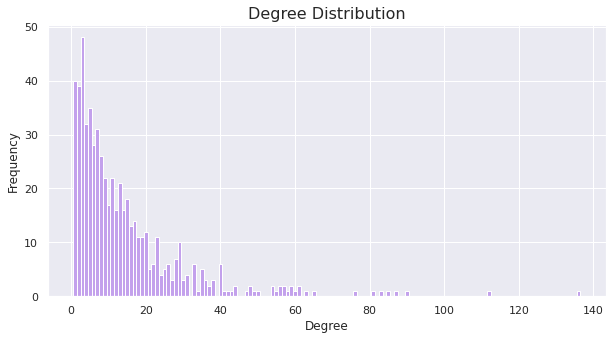

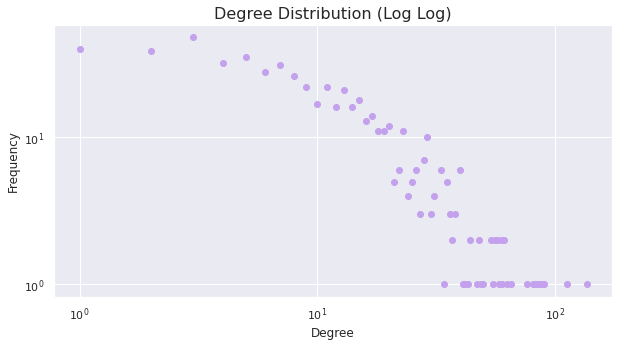

In [16]:
#Plot the degree distribution
degree_sequence = sorted([d for n, d in G.degree()])  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

sns.set()

fig, ax = plt.subplots(figsize=(10,5))
plt.bar(deg, cnt, width=1, color="#C3A1EC")
plt.title("Degree Distribution", fontsize=16)
plt.ylabel("Frequency", fontsize=12)
plt.xlabel("Degree", fontsize=12)

fig, ax = plt.subplots(figsize=(10,5))
plt.scatter(deg, cnt, color="#C3A1EC")
plt.xscale('log')
plt.yscale('log')
plt.title("Degree Distribution (Log Log)", fontsize=16)
plt.ylabel("Frequency", fontsize=12)
plt.xlabel("Degree", fontsize=12)

plt.show()

We observe that the degree distribution appears to follow a power law (approximately, at least) with many nodes having small degree and a few nodes having very large degree. This indicates that we are dealing with a scale-free network, which means that we expect the emergence of hubs in the network. A hub is simply a node with a number of connections that greatly exceeds the average. In this case, some hubs could be e.g. Snoop Dogg and Madonna.

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "type" which is no longer supported as of 3.3 and will become an error two minor releases later
  del sys.path[0]
/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "type" which is no longer supported as of 3.3 and will become an error two minor releases later


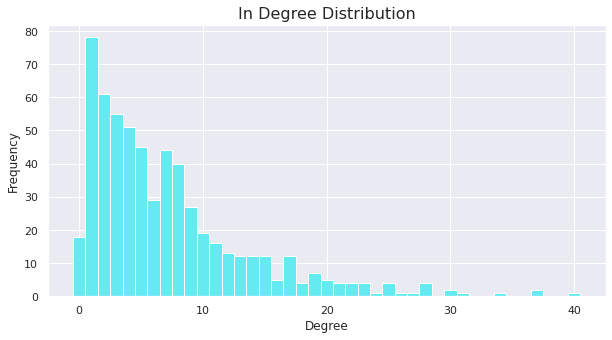

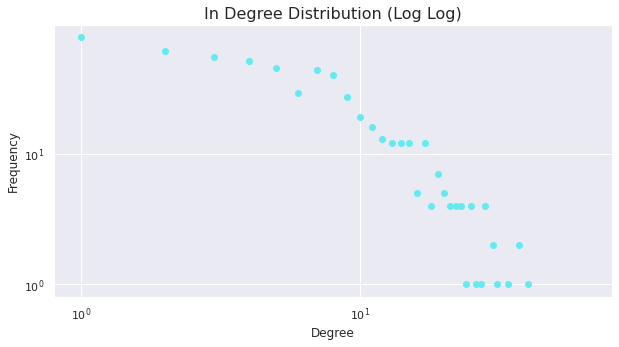

In [17]:
#Plot the in-degree distribution
degree_sequence = sorted([d for n, d in G.in_degree()])  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

sns.set()

fig, ax = plt.subplots(figsize=(10,5))
plt.bar(deg, cnt, width=1, color="#65EAF1")
plt.title("In Degree Distribution", fontsize=16)
plt.ylabel("Frequency", fontsize=12)
plt.xlabel("Degree", fontsize=12)
plt.savefig('INDegreeDistribution.png', type='PNG')

fig, ax = plt.subplots(figsize=(10,5))
plt.scatter(deg, cnt, color="#65EAF1")
ax.set_xscale('log')
ax.set_yscale('log')
plt.title("In Degree Distribution (Log Log)", fontsize=16)
plt.ylabel("Frequency", fontsize=12)
plt.xlabel("Degree", fontsize=12)
ax.set_xlim(0.8, np.max(deg)*2)
plt.savefig('INDegreeDistributionLog.png', type='PNG')

plt.show()

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "type" which is no longer supported as of 3.3 and will become an error two minor releases later
  del sys.path[0]
/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "type" which is no longer supported as of 3.3 and will become an error two minor releases later


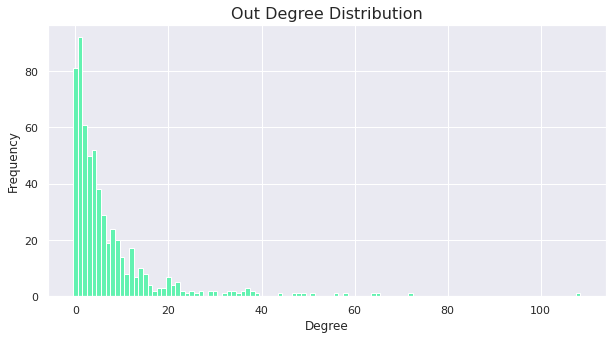

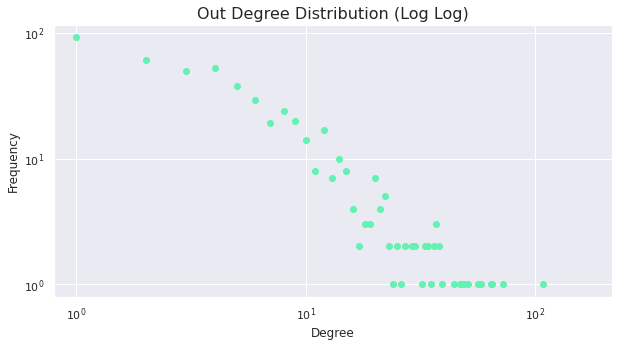

In [18]:
#Plot the out-degree distribution
degree_sequence = sorted([d for n, d in G.out_degree()])  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

sns.set()

fig, ax = plt.subplots(figsize=(10,5))
plt.bar(deg, cnt, width=1, color="#63F2B1")
plt.title("Out Degree Distribution", fontsize=16)
plt.ylabel("Frequency", fontsize=12)
plt.xlabel("Degree", fontsize=12)
plt.savefig('OUTDegreeDistribution.png', type='PNG')


fig, ax = plt.subplots(figsize=(10,5))
plt.scatter(deg, cnt, color="#63F2B1")
ax.set_xscale('log')
ax.set_yscale('log')
plt.title("Out Degree Distribution (Log Log)", fontsize=16)
plt.ylabel("Frequency", fontsize=12)
plt.xlabel("Degree", fontsize=12)
ax.set_xlim(0.8, np.max(deg)*2)
plt.savefig('OUTDegreeDistributionLog.png', type='PNG')


plt.show()

Next, we can construct a representation of the graph to show on the website. For a basic overview of the largest nodes, we will be constructing a graph using pyvis (it looks neat, and it's interactive!).
For a more complex graph with all artists, we will be usign networkx, as this allows for recoloring of edges (resulting in another cool graph!). The positions of the nodes will be
determined using ForceAtlas. 



In [19]:
# Ready graph for plotting
H = G.to_undirected()
H.remove_edges_from(list(nx.selfloop_edges(H)))
GCC = max((H.subgraph(c) for c in nx.connected_components(H)), key=len)
nodeDict = dict(GCC.nodes(data=True))

First, we determine the node positions with ForceAtlas.

In [137]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=4.0,
                        strongGravityMode=False,
                        gravity=0.5,

                        # Log
                        verbose=True)

# Determine node positions
positions = forceatlas2.forceatlas2_networkx_layout(GCC, pos=None, iterations=300)

100%|██████████| 300/300 [00:01<00:00, 186.78it/s]BarnesHut Approximation  took  0.72  seconds
Repulsion forces  took  0.74  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.02  seconds
AdjustSpeedAndApplyForces step  took  0.05  seconds



In order to make the basic graph, we will need to add a whole bunch of attributes to the nodes. These attributes will be used with the pyvis graph and a homemade networkx 
integration from this kind [person](https://gist.github.com/quadrismegistus/92a7fba479fc1e7d2661909d19d4ae7e) (the function has afterwards been adapted to fit our needs).

In [21]:
# Color node purple if dance pop artist, blue if west coast artist, green if both
color_dict = {}
for n in nodeDict:
    genre = nodeDict[n]['genre']

    if genre == 'Dance Pop':
        color_dict[n] = "#D8CBE8"
        
    elif genre == 'West Coast':
        color_dict[n] = "#A6CACE"

    elif genre == 'Both':
        color_dict[n] = "#B4D8AB"


# Make node size depend on degree of node
size_dict = {}
for n in nodeDict:
    size_dict[n] = GCC.degree[n]/2


# Define positions of nodes
xpos = {}
ypos = {}
for n in positions:
    xpos[n] = positions[n][0]
    ypos[n] = positions[n][1]


# Define node labels
label_dict = {}
i = 0
for n in nodeDict:
    label_dict[n] = n


# Define node titles
title_dict = {}
for n in nodeDict:
    neighbors = [nb for nb in GCC.neighbors(n) if GCC.degree[nb] > 15]
    title_dict[n] = "Neighbors:<br>" + "<br>".join(neighbors)

# Set node attributes to make pyvis work
nx.set_node_attributes(GCC, color_dict, "color")
nx.set_node_attributes(GCC, size_dict, "size")
nx.set_node_attributes(GCC, xpos, "x")
nx.set_node_attributes(GCC, ypos, "y")
nx.set_node_attributes(GCC, label_dict, "label")
nx.set_node_attributes(GCC, title_dict, "title")

In [22]:
# Please note that this networkx to pyvis integration was found here: https://gist.github.com/quadrismegistus/92a7fba479fc1e7d2661909d19d4ae7e
# A few adjustements have been made to fit our needs

def draw_graph3(networkx_graph,notebook=True,output_filename='graph.html',show_buttons=False,only_physics_buttons=False, hidden=False):
        """
        This function accepts a networkx graph object,
        converts it to a pyvis network object preserving its node and edge attributes,
        and both returns and saves a dynamic network visualization.

        Valid node attributes include:
            "size", "value", "title", "x", "y", "label", "color".

            (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_node)

        Valid edge attributes include:
            "arrowStrikethrough", "hidden", "physics", "title", "value", "width"

            (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_edge)


        Args:
            networkx_graph: The graph to convert and display
            notebook: Display in Jupyter?
            output_filename: Where to save the converted network
            show_buttons: Show buttons in saved version of network?
            only_physics_buttons: Show only buttons controlling physics of network?
        """

        # import
        from pyvis import network as net

        # make a pyvis network
        pyvis_graph = net.Network(notebook=notebook)
        pyvis_graph.width = '1000px'
        pyvis_graph.height = '800px'

        # for each node and its attributes in the networkx graph
        for node,node_attrs in networkx_graph.nodes(data=True):
            if hidden:
                if networkx_graph.degree[node] > 15:
                    pyvis_graph.add_node(node,**node_attrs, labelHighlightBold=True)
                else:
                    pyvis_graph.add_node(node,**node_attrs, labelHighlightBold=True, hidden=True)
            else:
                pyvis_graph.add_node(node,**node_attrs, labelHighlightBold=True)
        
        pyvis_graph.toggle_physics(False)

        # for each edge and its attributes in the networkx graph
        for source,target,edge_attrs in networkx_graph.edges(data=True):
            # if value/width not specified directly, and weight is specified, set 'value' to 'weight'
            if not 'value' in edge_attrs and not 'width' in edge_attrs and 'weight' in edge_attrs:
                # place at key 'value' the weight of the edge
                edge_attrs['value']=edge_attrs['weight']
            # add the edge
            if hidden:
                if GCC.degree[target] & GCC.degree[source] > 15:
                    pyvis_graph.add_edge(source,target,**edge_attrs)
                else:
                    pyvis_graph.add_edge(source,target,**edge_attrs, hidden=True)
            else:
                pyvis_graph.add_edge(source,target,**edge_attrs)

        # turn buttons on
        if show_buttons:
            if only_physics_buttons:
                pyvis_graph.show_buttons(filter_=['physics'])
            else:
                pyvis_graph.show_buttons()

        # return and also save
        return pyvis_graph.show(output_filename)


That was a lot of code just for a basic graph. But we're finally ready to construct it! As the function outputs an html file that we have not had success with displaying in this notebook, 
please refer to the website for viewing the graph. 

In [23]:
draw_graph3(GCC,output_filename='graph_output.html', notebook=False, hidden=True)

Next, we will ready our graph for plotting with networkx. The graph we aim to show now has has recolored edges that will show us whether a link is within the genre, or from one genre to the other.
And, just to make thing more complicated, networkx does not take attributes as input for node and edge coloring, meaning that we have to define everything as lists now. 

In [133]:
# color node purple if dance pop artist, blue if west coast artist, green if both
color_map = []
for n in nodeDict:
    genre = nodeDict[n]['genre']

    if genre == 'Dance Pop':
        color_map.append("#7C5C98")
        
    elif genre == 'West Coast':
        color_map.append("#41A3AD")

    elif genre == 'Both':
        color_map.append("#8fe685")

In [134]:
# make node size depend on degree of node
size = []
degrees = list(GCC.degree())

for i in range(len(GCC.nodes())):
    size.append(degrees[i][1] * 5)

In [135]:
#Colors for the edges
edge_colors = []

for u, v in GCC.edges():
    u_world = GCC.nodes[u]["genre"]
    v_world = GCC.nodes[v]["genre"]

    if u_world == "Dance Pop" and v_world == "Dance Pop":
            edge_colors.append("#C9B2E8") 
    elif u_world == 'West Coast' and v_world == "West Coast":
            edge_colors.append("#9BBEBA") 
    else:
            edge_colors.append("#E28B47")  

#Create a legend for the different colors and their meaning
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Dance Pop',
                          markerfacecolor="#7C5C98", markersize=10, alpha=0.6),
                   Line2D([0], [0], marker='o', color='w', label='West Coast',
                          markerfacecolor="#41A3AD", markersize=10, alpha=0.6),
                    Line2D([0], [0], marker='o', color='w', label='Both genres',
                          markerfacecolor="#8fe685", markersize=10, alpha=0.6),
                   Line2D([0], [0], color="#C9B2E8", label='Dance Pop to Dance Pop'),
                   Line2D([0], [0], color="#9BBEBA", label='West Coast to West Coast'),
                   Line2D([0], [0], color="#E28B47", label="Dance Pop to West Coast")]

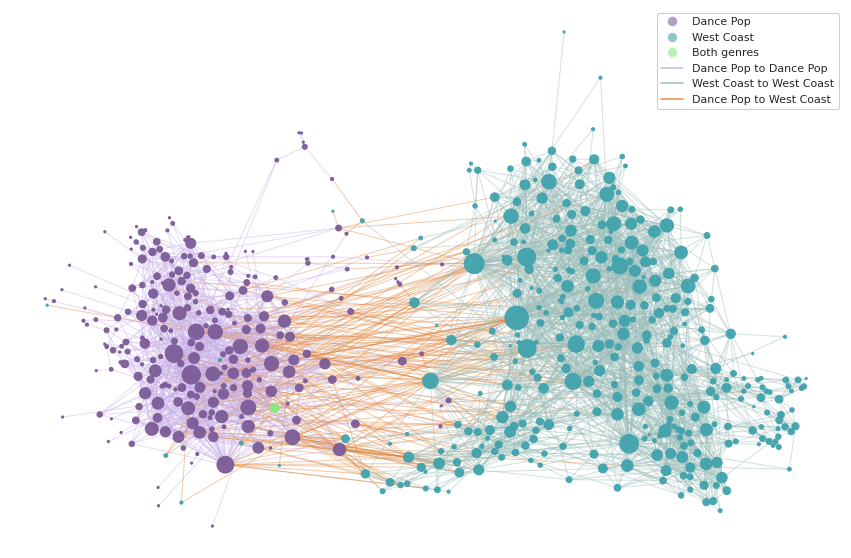

In [138]:
plt.figure(figsize=(15,10))
nx.draw_networkx_nodes(GCC, positions, node_size=size, node_color=color_map, alpha=0.95)
nx.draw_networkx_edges(GCC, positions, edge_color = edge_colors,  alpha=0.45)
plt.legend(handles=legend_elements, facecolor='white', framealpha=1)
plt.axis('off')
plt.savefig("BasicGraph.png", format="PNG")
plt.show()

## Analysis

The overall idea with this analysis is to study how two music genres might be connected.
We want to look into similarities and differences of the two music genres Dance Pop and
West Coast Hip Hop. To this analysis we will use network theory and neutral language
processing. 

In the following, we describe the different analysis tools that we have used in our analysis.



Describe which network science tools and data analysis strategies you've used, 
how those network science measures work, and why the tools you've chosen are right for 
the problem you're solving.

**Regular expressions:**

A regular expression is a sequence of characters that define a search pattern.
We have used regular expressions to identify links on the wikipages. These links is identified
and saved, such that we can use these links to create our network. 

**Unicode: ** 

using utf-8

**Further cleaning of text: ** 

Preparing the text for sentiment analysis and before calculating the TF-IDF scores, the words in
the text were transformed to lower case, all punctuation and stopwords removed and words 
which is not part of the lyrics or wikitext removed. 

**Communities (Partition into subgroups)**

We want to identify communities in the network, becuase we want to see if there is more 
divisions in the network besides the two genres. 

To identify the communities, we use a function that compute the partition of the graph nodes,
which maximises the modularity using the Louvain heuristices. The modularity of a network
indicates how dense connections between the nodes within communities is relative to 
connections between nodes in different communities.

When the communities are identified, we want to look into properties that define this division.

**TF-IDF: **

TF-IDF, which stands for "Term Frequency–Inverse Document Frequency", is a numerical 
statistic that is intended to reflect how relevant or important a word is to 
a corpus. The TF-IDF value increases proportionally to the number of 
times a word appears in the text and is offset by the number of texts in the corpus 
that contain the word, which helps to adjust for the fact that some words appear more 
frequently in general. 

TF stands for term frequency, and is calculated with a build-in function in Python. IDF
stand for Inverse document frequency and calculated as follows:
$IDF(t,D) = \log(N/(n_t+1))+1$
where $N$ is the number of documents and $n_t$ is the number of documents containing the term $t$.

When TF and IDF is calculated for all words in all documents, TFIDF can be calculated.
$TFIDF(t,d,D) = TF(t,d) \cdot IDF(t,D)$

We will use TF-IDF to create wordclouds for the communities and for the song lyrics.  

**TF-TR**

TF-TR is a technique from Sune's very own brain. TF-TR is used, as TF-IDF, to reflect how 
relevant/important a word is to a corpus of two documents. 

In general for some token $t$ with term frequency $TF^{(g)}_t$, in genre g where $g\in\{d,w\}$
, we define the weight as:

$w^{(d)}_t=TF^{(d)}_t/(TF^{(w)}_t+c)$

$w^{(w)}_t=TF^{(w)}_t/(TF^{(d)}_t+c)$ 

and calculate the TF-TR:

$TFTR^{(g)}_t=TF^{(g)}_t \cdot w^{(g)}_t$

We will use TF-TR to create wordclouds for the two genres.

**Wordclouds: **

A wordcloud is an image made of words that together resemble a cloudy shape. 
The size of each word shows how relevent it is e.g. how often it appears in a text, its frequency.
Wordclouds is used to easily produce a summary of larger textblocks. 

We have used TF-TR and TF-IDF to make our wordclouds. 




*How did you use the tools to understand your dataset?*

*Explain the overall idea*

**Analysis step 1 - Communities**

We are interested in whether, in addition to the two genres, there should be smaller 
communities in the network. If we can find communities in the network, we want to 
investigate the sizes of the communities, and the characteristics of each community. 
This would be based on text-analysis, such as wordclouds.

To identify the communities, we use the function "best_partition" from the python package 
"community", which is a pacage that implements community detection. The function compute 
the partition of the graph nodes which maximises the modularity using the Louvain heuristices.
The modularity of a network indicates how dense connections between the nodes within communities
is relative to connections between nodes in different communities. 

In [60]:
#first compute the best partition on the giant component
partition = community_louvain.best_partition(GCC)

In [61]:
# Number of communities
print("Number of communities:", max(partition.values())+1)

Number of communities: 12


In [62]:
# make list containing each community as a dictionary
community_dicts = []
for i in range(max(partition.values())):
    community_dict = {}
    for key in partition:
        if partition[key] == i:
            community_dict[key] = H.degree(key)
    community_dicts.append(community_dict)

We want to inspect how many nodes each community contain.

In [63]:
Communities = list(set(partition.values()))

Counter(list(partition.values())) # Count the number of different communities
Communities = Counter(list(partition.values())).most_common(13)
print(Communities)

[(0, 225), (9, 127), (10, 79), (4, 66), (1, 58), (11, 10), (5, 7), (8, 4), (2, 3), (3, 2), (6, 2), (7, 2)]


The network has five largest communities and some smaller ones.

We make a list with some of the names in each community. 
This is made to be able to look further down in which artists appear in the different 
communities.

In [64]:
# finding 10 names of the artists in each community
names = []
for comdict in community_dicts:
    name = nlargest(10, comdict, key=comdict.get)
    names.append((", ").join(name))

print(names)

['Madonna, Britney Spears, Rihanna, Michael Jackson, Lady Gaga, Nicki Minaj, Janet Jackson, Mariah Carey, Katy Perry, Justin Timberlake', 'Kendrick Lamar, Chris Brown, Wiz Khalifa, Dom Kennedy, Tyga, Problem, Ty Dolla $ign, YG, Nipsey Hussle, Schoolboy Q', 'Cut Copy, Black Kids, Junior Senior', 'Bronski Beat, The Communards', 'Alchemist, Planet Asia, Dilated Peoples, Fashawn, Blu, Murs, Evidence, Freddie Gibbs, Madlib, Strong Arm Steady', 'Exposé, Mars, The Cover Girls, t.A.T.u., Company B, Lisa Lisa and Cult Jam, Will to Power', 'Eiffel 65, Gabry Ponte', 'Jump5, ZOEgirl', 'Lisa Matassa, Brenda K. Starr, George Lamond, Judy Torres', 'Snoop Dogg, Dr. Dre, Ice Cube, The Game, Tha Dogg Pound, Kurupt, Eazy-E, N.W.A, DJ Quik, Kam', 'E-40, Tupac Shakur, 2Pac, Yukmouth, B-Legit, Dru Down, JT the Bigga Figga, C-BO, Spice 1, Mac Dre']


Now that we have found some communities in the network, we want to show the network, where the nodes are colored after which community they belong.

In [65]:
#Create a legend for the different colors and their meaning
legend_elements = [Line2D([0], [0], color="#C9B2E8", label='Dance Pop to Dance Pop'),
                   Line2D([0], [0], color="#9BBEBA", label='West Coast to West Coast'),
                   Line2D([0], [0], color="#E28B47", label="Dance Pop to West Coast")]

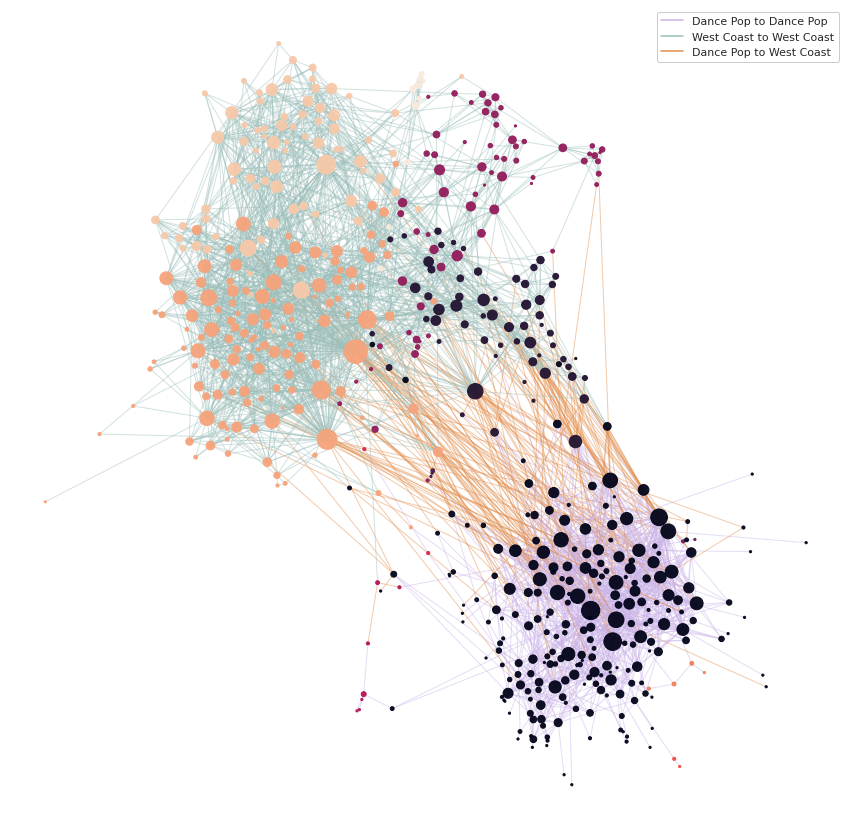

In [66]:
# The network of artists, colored by the communities

plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(GCC, positions, node_size=size, node_color=list(partition.values()), alpha=0.95)
nx.draw_networkx_edges(GCC, positions, edge_color = edge_colors,  alpha=0.45)
plt.axis('off')
plt.legend(handles=legend_elements, facecolor='white', framealpha=1)
plt.show()

The plot illustarte the communities. It is easy to see that there are five large communities. 
It is a little hard to find the small communities, but it make sense because they consist of 
only a few nodes. The nodes in the communities lies mostly within each genre, but there are a 
few communities that contain nodes from both genres.

We want learn more about these communities, and therefore we will make wordclouds on the five 
largest communities.

We start by making the wiki text ready to the wordclouds by removing punctuation, 
stopwords and other wierd word that appears in the wiki text. We set all the words to lowercase.

In [85]:
# Make a list with the five largest communities
Five = Counter(list(partition.values())).most_common(5)

Com = []

for i in Five:
    Com.append(i[0])

In [86]:
# Save the documents in a list with one list for each community

path = r'./wikipages_dance_pop/' 
dance_pop_files = glob.glob(path + "/*.txt")
path = r'./wikipages_west_coast/'
west_coast_files = glob.glob(path + "/*.txt")

community_corpus = []

for i in Com:
    document = []
    for file_path in dance_pop_files:
        with open(file_path, encoding="utf8") as f_input:
            if Path(file_path).stem in list(artists['Artist']):
                name = artists.loc[artists['Artist'] == Path(file_path).stem, 'Artist'].iloc[0]
                if name in list(partition.keys()) and partition[name] == i:
                    document.append(f_input.read())
    for file_path in west_coast_files:
        with open(file_path, encoding="utf8") as f_input:
            if Path(file_path).stem in list(artists['Artist']):
                name = artists.loc[artists['Artist'] == Path(file_path).stem, 'Artist'].iloc[0]
                if name in list(partition.keys()) and partition[name] == i:
                    document.append(f_input.read())
    document = " ".join(document)
    community_corpus.append(document)

In [87]:
word_corpus = []
for document in community_corpus:
    word_corpus.append(re.findall('\w+', document))

In [88]:
# Define punctuation and weird words
punctuation = string.punctuation + '``' + '--' + '|'
stopwords = nltk.corpus.stopwords.words('english')
weird = ["''", 'ref', '/ref', 'name=', '\'s', 'title', 'date', 'accessdate', 'https', 'n', 'cite', 'web', 'url', 'archive', 'access', 'publisher', 'u2014', 'category',
        'text', 'beyonc']
skip = stopwords + weird 

In [89]:
# clean the text
community_corpus_clean = []

for document in word_corpus:
    # remove punctuation and set to lower case
    community_corpus_clean.append([word.lower() for word in document if word not in skip])

In [90]:
# Calculate the term frequency (TF) of each word
document_TF = []

for document in community_corpus_clean:
    document_TF.append(nltk.FreqDist(document))

In [91]:
# Calculate the TFTR
TFTR = [{} for i in range(0, len(document_TF))]
   
for i in range(0, len(document_TF)):
    for key in document_TF[i]:
        if key not in skip:
            TFTR[i][key] = document_TF[i][key]

In [92]:
import math

# calculate IDF for each word in each community
IDF = []
for document in TFTR:
    idf = {}
    N = len(community_corpus_clean)
    appear = 0
    for word in document:
        appear = sum(1 for doc in TFTR if (word in doc))    
        idf[word] = math.log(N/(1 + appear), 2) + 1
    IDF.append(idf)

In [93]:
# Calculte TFIDF for each word in each community
TFIDF = []
for i in range(0, len(IDF)):
    tfidf = {}
    for word in IDF[i]:
        tfidf[word] = IDF[i][word] * TFTR[i][word]
    TFIDF.append(tfidf)

In [94]:
wordlist = []

for document in TFIDF:
    community_list = []
    for word in document:
        val = math.ceil(document[word]/10)
        community_list.extend([word] * val)
    community_list = (" ").join(community_list)
    wordlist.append(community_list)

Now we have calculated the TFIDF for each word in each community, and we can create wordclouds
for the five communities.

In [95]:
wordcloud = []
for i in range(0, len(wordlist)):
    wordcloud.append(WordCloud(max_font_size=40, collocations = False, background_color='white').generate(wordlist[i]))

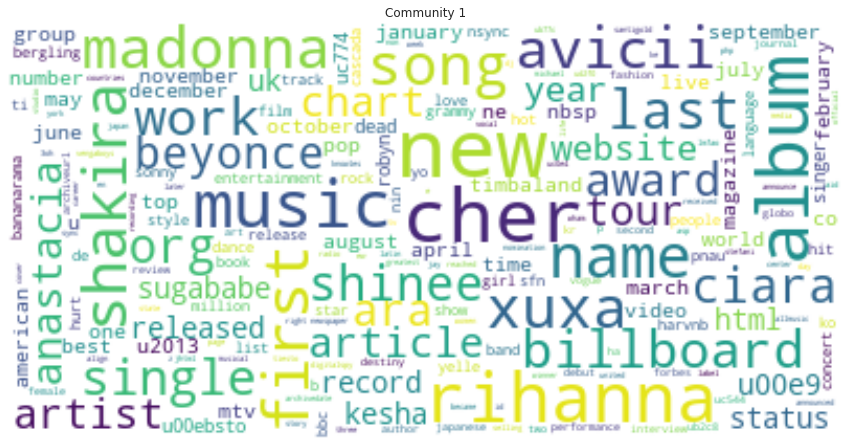

In [96]:
title = "Community 1"
plt.figure(figsize=(15,20))
plt.title(title)
plt.axis("off")
plt.imshow(wordcloud[0], interpolation="bilinear")

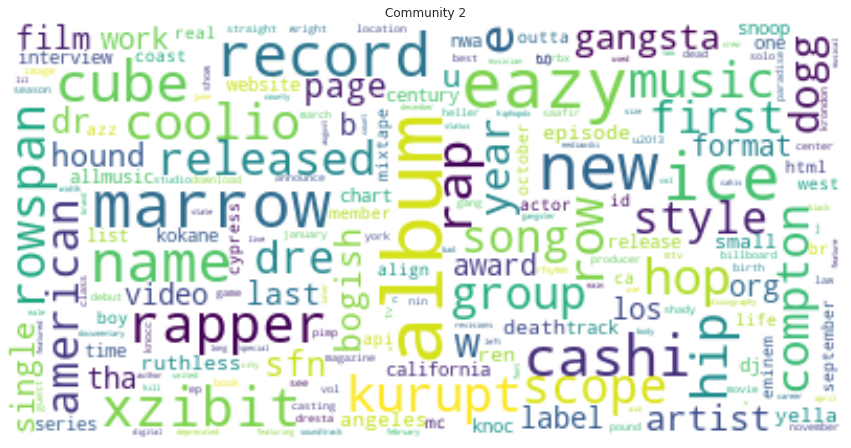

In [97]:
title = "Community 2"
plt.figure(figsize=(15,20))
plt.title(title)
plt.axis("off")
plt.imshow(wordcloud[1], interpolation="bilinear")

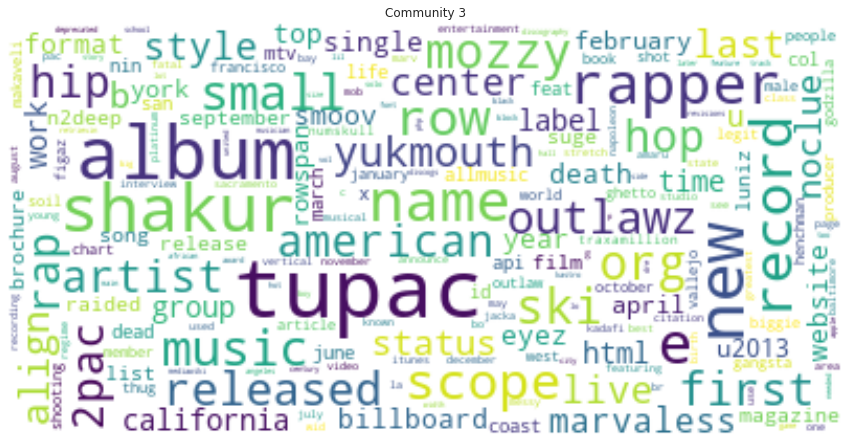

In [98]:
title = "Community 3"
plt.figure(figsize=(15,20))
plt.title(title)
plt.axis("off")
plt.imshow(wordcloud[2], interpolation="bilinear")

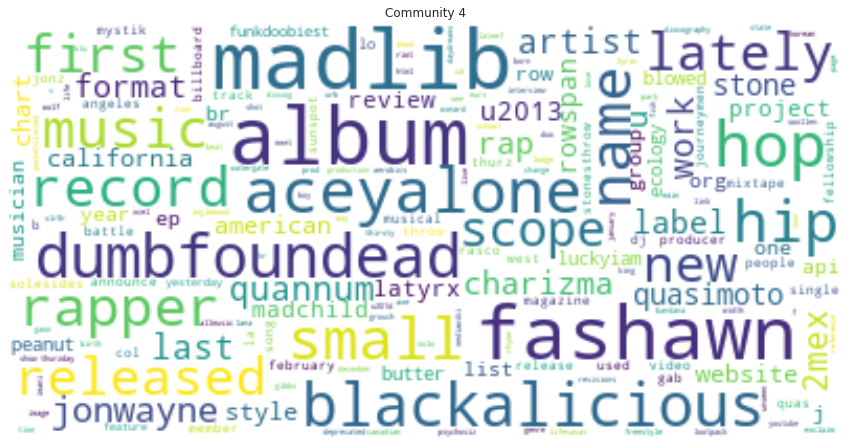

In [99]:
title = "Community 4"
plt.figure(figsize=(15,20))
plt.title(title)
plt.axis("off")
plt.imshow(wordcloud[3], interpolation="bilinear")

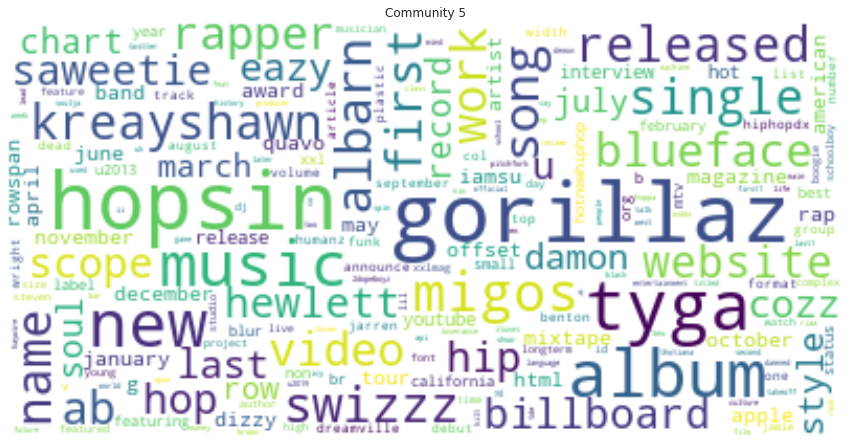

In [100]:
title = "Community 5"
plt.figure(figsize=(15,20))
plt.title(title)
plt.axis("off")
plt.imshow(wordcloud[4], interpolation="bilinear")

The five wordclouds contain the names of the artists in each community. The size of thw words
indicate their relevance, and based on this we can see which artists
are the most relevant within the various communities.

**Analysis step 2 - Sentiment analysis of the artists**

We want to continue our investigation of the differences between the two genres, 
with a sentiment analysis of the artists wikipages. Sentiment analysis refers to a text 
analysis to systematically identify and study subjective information in a text. 

We have used the LabMT wordlist, to create our sentiment analysis. 
This wordlist contains information about how happy each word on the list is, 
and based on this list we can look into how happy or sad each artists wikipage is. 

In [103]:
# Download the LabMT wordlist
LabMT = pd.read_csv('Data_Set_S1.txt', sep= "\t")

LabMT.head()

word  happiness_rank  happiness_average  happiness_standard_deviation  \
0   laughter               1               8.50                        0.9313   
1  happiness               2               8.44                        0.9723   
2       love               3               8.42                        1.1082   
3      happy               4               8.30                        0.9949   
4    laughed               5               8.26                        1.1572   

  twitter_rank google_rank nyt_rank lyrics_rank  
0         3600          --       --        1728  
1         1853        2458       --        1230  
2           25         317      328          23  
3           65        1372     1313         375  
4         3334        3542       --        2332

We have defined a sentiment function, to calculate the sentiment of a list of tokens.

In [104]:
# The sentiment function
def sentiment(tokens):
    df = pd.DataFrame(tokens,columns=['word'])
    return pd.DataFrame(df, columns=['word']).merge(LabMT, on = 'word').happiness_average.mean()

We prepare the texts for the analysis

In [108]:
# save the paths to the wikipages in two lists
westcoast_list = glob.glob(os.path.join(os.getcwd(), '/home/jovyan/work/wikipages_west_coast', "*.txt"))
dancepop_list = glob.glob(os.path.join(os.getcwd(), '/home/jovyan/work/wikipages_dance_pop', "*.txt"))

In [109]:
# make a dictionary containing the wiki text for each artist
artists_dict = {}
for file_path in westcoast_list:
    with open(file_path, encoding="utf8") as f_input:
        artists_dict[Path(file_path).stem] = f_input.read()
for file_path in dancepop_list:
    if ((file_path != '/home/jovyan/work/wikipages_dance_pop/The_New_Standard_(newspaper).txt') & (file_path != '/home/jovyan/work/wikipages_dance_pop/Chart_Attack.txt') & (file_path != '/home/jovyan/work/wikipages_dance_pop/The_Chosun_Ilbo.txt')):
        with open(file_path, encoding="utf8") as f_input:
            artists_dict[Path(file_path).stem] = f_input.read()

Now that the wikipages are ready, we can calculate the sentiment score for each of them.

In [110]:
# calculate the sentiment for every single wikipage
page_sentiment = dict()

for key in artists_dict:
    tokens = word_tokenize(artists_dict[key])
    page_sentiment[key] = sentiment(tokens)

In [111]:
# clean the page sentiment dictionary from nan values
clean = {k: v for k, v in page_sentiment.items() if pd.Series(v).notna().all()}

Now we have created a dictionary with a sentiment value for each artists wikipage. 
We want to find the five happiest and the five saddest artists based on their wikipages.

In [112]:
# happiest pages
s = pd.Series(clean)
s.nlargest(5)

Expos\u00e9_(group)       5.920000
Kim_Hyun-jung_(singer)    5.755022
Sarina_Paris              5.696423
Samantha_James            5.675948
Paul_Pesco                5.667935
dtype: float64

In [113]:
# saddest pages
s = pd.Series(clean)
s.nsmallest(5)

Mac_Minister      5.132569
Dresta            5.245564
Madchild          5.248856
Cougnut           5.250703
Bloods_&_Crips    5.261402
dtype: float64

Based on the wikipages, the five happiest artists are dance pop artists, 
while the five saddest artist are west coast artists. It seems like there is a link between
the genre and the sentiment of the wikipage. 

To look deeper into the sentiment of the two genres, we create a distribution plot showing the 
sentiment for all artists and calculate the average sentiment for each genre.

In [114]:
# make two dicts containing all pages
dancepop_dict = {}
westcoast_dict = {}
for file_path in westcoast_list:
    with open(file_path, encoding="utf8") as f_input:
        westcoast_dict[Path(file_path).stem] = f_input.read()
for file_path in dancepop_list:
    if ((file_path != '/home/jovyan/work/wikipages_dance_pop/The_New_Standard_(newspaper).txt') & (file_path != '/home/jovyan/work/wikipages_dance_pop/Chart_Attack.txt') & (file_path != '/home/jovyan/work/wikipages_dance_pop/The_Chosun_Ilbo.txt')):
        with open(file_path, encoding="utf8") as f_input:
            dancepop_dict[Path(file_path).stem] = f_input.read()

In [115]:
# calculate the sentiment for every single wikipage
dancepop_sentiment = dict()

for key in dancepop_dict:
    tokens = word_tokenize(dancepop_dict[key])
    dancepop_sentiment[key] = sentiment(tokens)

westcoast_sentiment = dict()

for key in westcoast_dict:
    tokens = word_tokenize(westcoast_dict[key])
    westcoast_sentiment[key] = sentiment(tokens)

In [117]:
import statistics

In [118]:
dancepop_cleaned = [x for x in list(dancepop_sentiment.values()) if str(x) != 'nan'] # removes nan's
dancepop_mean = statistics.mean(dancepop_cleaned)
dancepop_median = statistics.median(dancepop_cleaned)
print("Dance pop average:", dancepop_mean)

Dance pop average: 5.507541127391463


In [119]:
westcoast_cleaned = [x for x in list(westcoast_sentiment.values()) if str(x) != 'nan'] # removes nan's
westcoast_mean = statistics.mean(westcoast_cleaned)
westcoast_median = statistics.median(westcoast_cleaned)
print("West coast average:", westcoast_mean)

West coast average: 5.464069335421246


Find the minimum and maximum sentiment value of the artists wikipages.

In [123]:
cleanedList = [x for x in list(page_sentiment.values()) if str(x) != 'nan']
artists_min = min(cleanedList)
artists_max = max(cleanedList)
artists_mean = statistics.mean(cleanedList)
artists_std = statistics.stdev(cleanedList)
print("Min:", artists_min)
print("Max:", artists_max)
print("Mean:", artists_mean)
print("Standard deviation:", artists_std)

Min: 5.132569444444444
Max: 5.919999999999999
Mean: 5.487124297698357
Standard deviation: 0.08101230041192592


The average of the sentiment for the Dance Pop artists is 5.508, while the average of the 
sentiment for the West Coast artists is 5.464. This confirms that it seems like the dance pop
artists wikipages are more happy than the west coast artists wikipages.

In respect to that the minimum sentiment value for the pages is 5.133 and the maximum sentiment 
value is 5.920 the difference between the genres is not that large, but still to see.

A distribution plot for the sentiments of the pages is shown below.

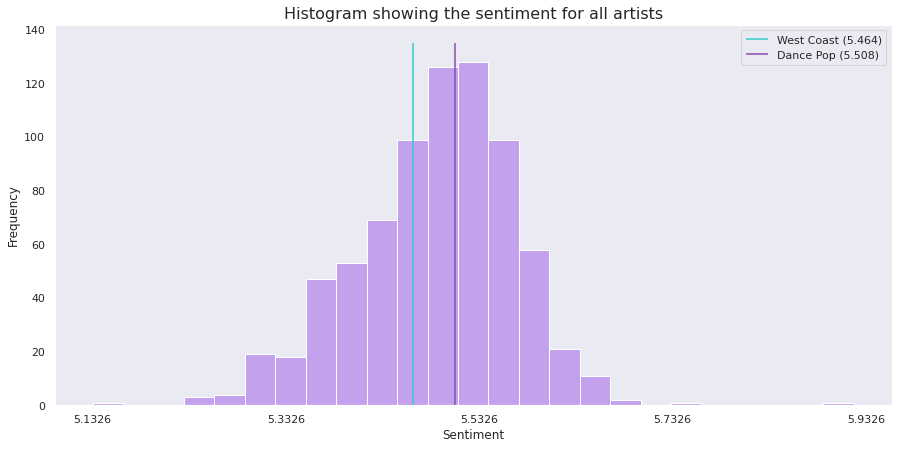

In [124]:
plt.figure(figsize = (15,7))
plt.vlines([westcoast_mean],0,135,color='#33CCCC')
plt.vlines([dancepop_mean],0,135,color='#8b4daf')
plt.legend([f'West Coast ({np.round(westcoast_mean,3)})',f'Dance Pop ({np.round(dancepop_mean,3)})'])
plt.hist(cleanedList,25,color='#C3A1EC')
plt.ylabel('Frequency', fontsize = 12)
plt.xlabel('Sentiment', fontsize = 12)
plt.xticks(np.arange(min(cleanedList), max(cleanedList)+0.2, 0.2))
plt.grid(False)
plt.title('Histogram showing the sentiment for all artists', fontsize = 16)
plt.savefig('SentimentArtists.png', format='PNG')
plt.show()

From the distribution plot it appears that the sentiment scores for the artists wikipages follow a left skewed normal distribution, with mean 5.487 and standard deviation 0.081. The wikipages do not differ that much in sentiment score.

We want to look deeper into the sentiment of some artists. We select the five most connected
artists from each genre and calculate the sentiment of these.

In [127]:
# Dance Pop artists
print('Dance Pop artists:')
print("Britney Spears:", sentiment(word_tokenize(artists_dict['Britney_Spears'])))
print("Madonna:", sentiment(word_tokenize(artists_dict['Madonna'])))
print("Rihanna:", sentiment(word_tokenize(artists_dict['Rihanna'])))
print("Nicki_Minaj:", sentiment(word_tokenize(artists_dict['Nicki_Minaj'])))
print("Janet Jackson:", sentiment(word_tokenize(artists_dict['Janet_Jackson'])))
print('\n')
print('West Coast artist:')
# West Coast artists
print("Snoop Dogg:", sentiment(word_tokenize(artists_dict['Snoop_Dogg'])))
print("Dr. Dre:", sentiment(word_tokenize(artists_dict['Dr._Dre'])))
print("Ice Cube:", sentiment(word_tokenize(artists_dict['Ice_Cube'])))
print("E-40:", sentiment(word_tokenize(artists_dict['E-40'])))
print("The Game:", sentiment(word_tokenize(artists_dict['Game_(rapper)'])))

Dance Pop artists:
Britney Spears: 5.5152857142857155
Madonna: 5.547905392060044
Rihanna: 5.543069901513332
Nicki_Minaj: 5.489921759071902
Janet Jackson: 5.547866407263294


West Coast artist:
Snoop Dogg: 5.406427824267783
Dr. Dre: 5.4401519439892745
Ice Cube: 5.477392996108949
E-40: 5.516515624999999
The Game: 5.37325615352524


Madonna, Janet Jackson, and Rihanna from the dance pop genre have the highest sentiment scores, 
while The Game, Snoop Dogg and Dr. Dre from the West Coast genre have the lowest sentiment scores.
Which again confirm the theory about the sentiment of the two genres.

E-40 have sentiment score which are similar to the sentiment scores of the dance pop artists.

Now we want to deeper into the sentiment of the two genres by analyse the lyrics of the songs.

**Analysis step 3 - Artist Sentiment based on songs**

In this part we wanted to take analyse language usage for the nodes/artist with highest degrees. The aim is to figure out 
how the sentiment is an indicator for the language and which words are characteristic for one or booth genre. The hope is that 
by analysing the language, we can understand why some artist collaberates more between the genres than others. Somewhere there
must be a connection in the way they share their feelings, ideas and thoughts through song lyrics. 

Lets start by analysing the degrees and connections in the network created trough links on the the artist wikipages. 

In [ ]:
n_link_Genres = sum([1 if G.nodes[e[0]]['genre'] != G.nodes[e[1]]['genre'] else 0 for e in G.edges()])
print("There is %s links connecting Dance Pop and West Coast artist."%n_link_Genres)

In [ ]:
degree_dance_pop = [(n, G.degree[n]) for n, attr in G.nodes(data=True) if attr['genre'] == 'Dance Pop']
sorted_degree_dp = sorted(degree_dance_pop, key = lambda i: i[1],reverse=True)
print("The five most connected Dance Pop artists: %s" %sorted_degree_dp[:5])

In [ ]:
degree_west_coast = [(n, G.degree[n]) for n, attr in G.nodes(data=True) if attr['genre'] == 'West Coast']
sorted_degree_wc = sorted(degree_west_coast , key = lambda i: i[1],reverse=True)
print("The five most connected Dance Pop artists: %s" %sorted_degree_wc[:5])

Following some of the results in the previous analysis, there is a large number of artist collaberating between the two genres. 
The connections between the two genres is 257, where the total number of links in the network is 4247. 

Now we continue the analysis of the network by focusing on the top five most connected artist in each genre. Our aim is
to see how the collaberation is reflected in the use of words. To investigate this, we will look at the sentiment for each artist 
and create a WordCloud based on their songs. 



In [ ]:
def clean_songs(input_text): 
    string_of_text = ','
    words = string_of_text.join([song.replace('\\n',' ').replace('\\t',' ') for song in input_text[2:-2].split("', '")]).split()
    weird = ['Chorus', 'verse', 'Intro'] # Remove none lyric words 
     # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    result_out_punctuation = [w.translate(table) for w in words if len(w)>3]
    return [w.lower() for w in result_out_punctuation if w not in weird]

In [ ]:
def TF_IDF(row): 
    clean_play_list = clean_songs(row)
    string_clean_play_list = nltk.tokenize.word_tokenize(" ".join(clean_play_list))
    TF = nltk.FreqDist(string_clean_play_list)

    IDF = dict()
    TF_IDF = dict()
    N = len(clean_play_list)
    #print(N)
    for word in set(string_clean_play_list):
        count = 0 
        for song in range(len(clean_play_list)): 
            if word in clean_play_list[song]: 
                count = count +1
        IDF[word] = (math.log(N/(count+1),2))
        TF_IDF[word] = TF.get(word)*IDF[word]
    return TF_IDF

In [ ]:
def sentiment_wordcloud_artist(row): 
    tokens = clean_songs(row[5])
    scores = apply_sentiment(tokens)
    TF_IDF_list = TF_IDF(row[5])

    wordcloud = WordCloud(max_font_size=40, collocations = False, background_color='white').generate((" ").join(TF_IDF_list))
    plt.figure()
    plt.figure(figsize=(20,30))
    if row[2] == 'Dance Pop': 
        plt.imshow(wordcloud.recolor(color_func=red_color_func, random_state=3), interpolation="bilinear")
    else: 
        plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(row[0]+ ' with sentiment score: '+str(round(scores,2)), fontsize=22)
    plt.savefig(row[0]+'.png')

So for each of the artist with the highest degrees lets calculate the TF-IDF word frequence and average sentiment scores and 
plot it in a wordcloud. 

In [ ]:
# Reading artist from csv files 
artist_dance_pop_df = pd.read_csv('song_dance_pop_df.csv', sep = '\t')
del artist_dance_pop_df['Unnamed: 0']
artist_dance_pop_df.head()

artist_west_coast_df = pd.read_csv('song_west_coast_df.csv', sep = '\t')
del artist_west_coast_df['Unnamed: 0']
artist_west_coast_df.head()

In [ ]:
for key, val in sorted_degree_dp[:5]: 
    row = artist_dance_pop_df.loc[artist_dance_pop_df['Artist'] == key]
    sentiment_wordcloud_artist(row.values[0])

In [ ]:
for key, val in sorted_degree_wc[:5]: 
    row = artist_west_coast_df.loc[artist_west_coast_df['Artist'] == key]
    sentiment_wordcloud_artist(row.values[0])

First, lets take a look at the defining artist in Dance Pop and the words which defines there music. 
The artist in Dance Pop with highest degree (booth in- and out-degrees) are Britney Spears 90, Madonna 87, Rihanna 76, 
Nicki Minaj 61 and Janet Jackson 59. The defining words for this genre is love, boy, dream, life and God to just name a few. 
The charactics is the positive wording and the lyrics is defined by the fact that most song is about big themes like love, 
dreams and God. The words has a high happiness average with love 8.42, dream 7.44 and God 7.28, and since those words are common the 
sentiment for the artist in the Dance Pop genre tends to in the higher end. The wording is not only positive, in the lyrics we also finds 
words like cry with an average happiness score of 1.84, hurt with 2.18 and heartbreak with 2.11.    
This aligns well its with the sentiment of the lyrics, where all top 5 artist is above 5.5 except Nicki Minaj. 
If we take a close look at her and the artists she has collaberated with, she has worked with a number of West Coast Hiphop 
artist aswell as Dance Pop artist. She is well known for her rapping skills, and the more hardcore language and word bombs is 
therefor a hugh part of her WordCloud and sentiment score.

Now lets analyse the song lyrics of the top five most connected artist in the West Coast genre. 
The artists with highest degrees are Snoop Dogg 136, Dr. Dre 112, Ice Cube 85, E-40 83 and The Game 81. 
The sentiment for all top five artist in the West Coast genre is lower than average Dance Pop artist.  
They use a more harsh language which is clear when looking at the sentiment scores aswell as the individual WordClouds. 
Some of the repeating words in the WordClouds are mean, bitch and motherfucker, but also love and God/heaven/dream. 
While mean with a happiness average of 3.68, bitch with 3.14 and motherfucker 2.02 is in the lower end, 
the positive words are all above 7.5 in happiness score. 
So eventhough we would characterize the genre by the harsh language, it contains many positive words aswell. 
(So even the hardcore rappers has a softside...)


**Analysis step 4 - Song Sentiment over time**

In this part we wanted to investigate if the sentiment of the songs change over time. This were
done to see if the two genre over time becomes more similar or is drifting apart. Hopefully if the 
two genres has some of the same spikes or pits, we could link those to real life events. For each 
genre we take the songs which have an release date on Genius, group them by year
and then take the average sentiment of songs in each group.   

In this section we will use sentiment scores based on each individual song. Then to dig 
a little deeper, we will find some spikes and  pits in from the average sentiment, and 
show the most segnificant words for that year using TF-IDF word scores and wordclouds.  

In [ ]:
import nltk
from nltk import word_tokenize
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from wordcloud import WordCloud 

import regex as re
import string

import math
import json
import random

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Reading artist from csv files 
lyric_dance_pop_df = pd.read_csv('lyric_info_dance_pop_df.csv', sep = '\t')
del lyric_dance_pop_df['Unnamed: 0']
lyric_dance_pop_df  = lyric_dance_pop_df[lyric_dance_pop_df.release_date != 'unidentified']

lyric_west_coast_df = pd.read_csv('lyric_info_west_coast_df.csv', sep = '\t')
del lyric_west_coast_df['Unnamed: 0']
lyric_west_coast_df = lyric_west_coast_df[lyric_west_coast_df.release_date != 'unidentified']
lyric_west_coast_df.head()

title release_date artist  artist_id  \
0               ’92 Gator   2012-10-22   100s    49243.0   
1          Bout That Life   2012-10-01   100s    49243.0   
2      Can A Nigga Hit It   2014-03-06   100s    49243.0   
3  Different Type Of Love   2014-03-06   100s    49243.0   
4           Fuckin Around   2014-03-06   100s    49243.0   

                featured_artists  genius_track_id       genre  \
0                             []           244153  West Coast   
1  ['J Folks', 'Chippy Nonstop']           245666  West Coast   
2                             []           417153  West Coast   
3                     ['Cherub']          2311303  West Coast   
4                             []           376104  West Coast   

                                         Song Lyrics  
0  \n\nIntro from "The Other Guys" voiced by Will...  
1  \n\n[Intro: 100s & Chippy Nonstop]\nShout out ...  
2  \n\n[Verse 1]\nSee, an ass like that take cont...  
3  \n\n[Verse 1]\nHit a quick hair flip and I'm d...  
4  \n\n[Hook]\nI think it's time I let you know\n...

For this analysis part, we use the csv-files which contains a row for each song in the genre. 
Then delete all rows were the release date is unidentified, since we are not going to use
them in this case. In the following we create a new dictionary with the sentiment of each song 
as an extra attribute. 

In [ ]:
def sentiment_song(df):
    sentiment_info = dict()
    count_songs = 0
    for index, row in df.iterrows():  
        song_sent = dict()
        song_sent['song_title'] = row['title'] 
        song_sent['artist'] = row['artist']
        song_sent['year'] = row['release_date'][:4]

        # Calculate sentiment average 
        tokens = clean_songs(row['Song Lyrics'])
        scores = apply_sentiment(tokens)
        song_sent['sentiment'] = scores
            
        if not np.isnan(scores): 
            sentiment_info[count_songs] = song_sent
            count_songs +=1

    return sentiment_info

In [ ]:
sentiment_info_dance_pop = sentiment_song(lyric_dance_pop_df)
sentiment_info_west_coast = sentiment_song(lyric_west_coast_df)

To see the line chart of the avarge sentiemnt pr. year for booth genre, you need to go to our
webpage, since its an interaktive chart written in html. In the following snippets of code, 
we will show have we prepared the data for the interaktive chart.  


In [ ]:
# Prepare data for line plot 
def func_year_sentiment(df): 
    year_sentiment_dict = dict()
    for key in df.keys(): 
        val = df[key]
        year = int(val['year'])
        if not (year > 2020 or year <1920): 
            if not val['year'] in year_sentiment_dict: 
                year_sentiment_dict[val['year']] = []
            year_sentiment_dict[val['year']].append(val['sentiment'])
    return year_sentiment_dict
year_sentiment_dict_dp = func_year_sentiment(sentiment_info_dance_pop)
year_sentiment_dict_wc = func_year_sentiment(sentiment_info_west_coast)


def get_tooltip_html(year, sent, num_songs):
    return """
<div class="p-2">
  <h3><i class="fas fa-music"></i> {}</h3>
  <i class="far fa-file-alt"></i> Sentiment: {} <br>
  <i class="fas fa-microphone-alt"></i> Based on {} songs
</div>
    """.format(year, round(sent, 2), num_songs)

data_points = []
for year in range(1969, 2021):
    sent_dance_pop = None
    sent_west_coat = None
    tooltip_dance_pop = None
    tooltip_west_coat = None

    if str(year) in year_sentiment_dict_dp:
        sentiments = year_sentiment_dict_dp[str(year)]
        sent_dance_pop = sum(sentiments)/len(sentiments)
        tooltip_dance_pop = get_tooltip_html(year, sent_dance_pop, len(sentiments))
    
    if str(year) in year_sentiment_dict_wc:
        sentiments = year_sentiment_dict_wc[str(year)]
        sent_west_coat = sum(sentiments)/len(sentiments)
        tooltip_west_coat = get_tooltip_html(year, sent_west_coat, len(sentiments))

    data_points.append([str(year), sent_dance_pop, tooltip_dance_pop, sent_west_coat, tooltip_west_coat])

print(str(data_points).replace("None", "null"))

The chart clearly had some spikes and pits, and the two genre seemed to follow the same pattern. 
Therefor we want to look deeper into the words for certain years. Could we see why the sentiment 
behaved like it did. Could we by using TF-IDF and wordclouds gain some insight into why 
sentiment rised and fell from year to year. We choose to investigate two different years 
1996 and 2007, for similarities and differences in significant words those years.  

In [ ]:
def clean_songs(input_text): 
    string_of_text = ','
    words = string_of_text.join([song.replace('\\n',' ').replace('\\t',' ') for song in input_text[2:-2].split("', '")]).split()
    weird = ['Chorus', 'verse', 'Intro'] # Remove none lyric words 
     # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    result_out_punctuation = [w.translate(table) for w in words if len(w)>3]
    return [w.lower() for w in result_out_punctuation if w not in weird]

In [ ]:
def TF_IDF(row): 
    clean_play_list = clean_songs(row)
    string_clean_play_list = nltk.tokenize.word_tokenize(" ".join(clean_play_list))
    TF = nltk.FreqDist(string_clean_play_list)

    IDF = dict()
    TF_IDF = dict()
    N = len(clean_play_list)
    #print(N)
    for word in set(string_clean_play_list):
        count = 0 
        for song in range(len(clean_play_list)): 
            if word in clean_play_list[song]: 
                count = count +1
        IDF[word] = (math.log(N/(count+1),2))
        TF_IDF[word] = TF.get(word)*IDF[word]
    return TF_IDF

In [ ]:
def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        return "hsl(%d, 100%%, %d%%)" %(213+random.randint(50, 150), random.randint(50, 90))

def year_wordClouds(df, year, title, recolor = True): 
    lyrics_string = []
    for index, row in df.iterrows(): 
        if row['release_date'][:4] == year: 
            lyrics_string.append(row['Song Lyrics'])
        
    TF_IDF_list = TF_IDF(str(lyrics_string))

    wordcloud = WordCloud(max_font_size=40, collocations = False, background_color='white').generate((" ").join(TF_IDF_list))
    plt.figure()
    plt.figure(figsize=(10,15))
    if recolor: 
        plt.imshow(wordcloud.recolor(color_func=red_color_func, random_state=3), interpolation="bilinear")
    else: 
        plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=22)



<Figure size 432x288 with 0 Axes>

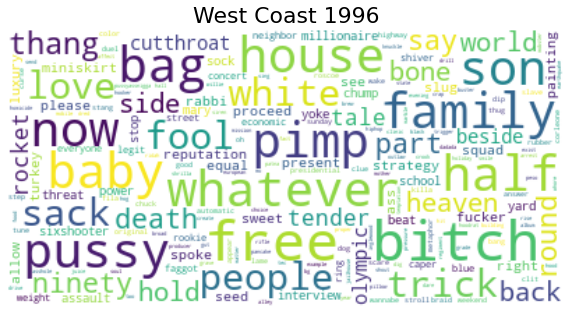

<Figure size 432x288 with 0 Axes>

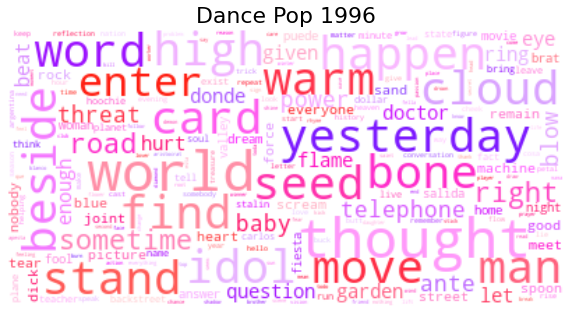

In [ ]:
year_wordClouds(lyric_west_coast_df, '1996', 'West Coast 1996', False)
year_wordClouds(lyric_dance_pop_df, '1996', 'Dance Pop 1996')

<Figure size 432x288 with 0 Axes>

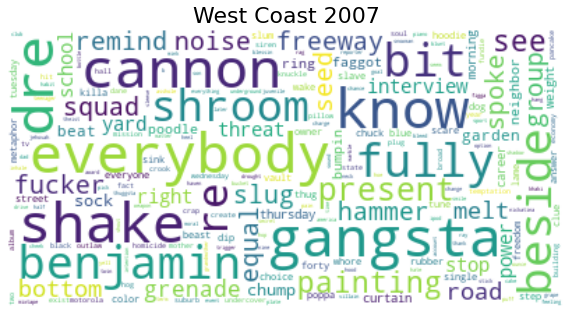

<Figure size 432x288 with 0 Axes>

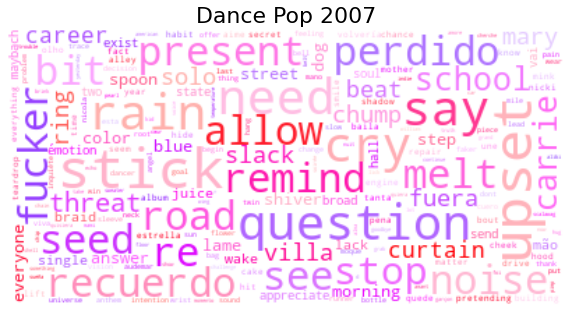

In [ ]:
year_wordClouds(lyric_west_coast_df, '2007', 'West Coast 2007', False)
year_wordClouds(lyric_dance_pop_df, '2007', 'Dance Pop 2007')

The line plot gives some insight into how each genre evolves by showing the changes in sentiment through time. 
The average sentiment for all songs in the Dance Pop genre is 5.57 and in the West Coast genre is 5.32.  
The average sentiment is based on all songs booth those with a date and those with a unidentified date. The line plot
is only based upon those song, were there were given a specific release date. So some uncertainty is coused by the lack of 
dates on all songs. Approximately half of the song where given without release date, and for the West Coast genre
this has caused a higher sentiment score. The line plot still gives some valuable insight into the change in sentiment 
for each genre and a simple way to compare the two. 

We assumed all songs produced by the Dance Pop artist to be in the category Dance Pop, but this is a non trivial assumption
since Artist can switch genre. Some of the major artist in the Dance Pop category like Nicki Minaj may define herself as 
an Rap artist or some of her songs as rap songs. We tried to take this into account early by defining some nodes to be in 
booth categories.   

So since all the songs of an artist is assumed to de of one genre, then even though the Dance Pop genre started in 
the early 1980, we see some songs has been released before that. On the contrary the origins of West Coast 
trace back to the late 1970s, which explains why our chart only shows songs from 1982 to today. Based on our understading 
of the West Coast genre, the artist started and stayed true to the genre through out their music career. Where the Dance Pop
artist also produce music in Pop, R&B or other similar genres.   

The sentiment rises and falls over time and some years like 1996, the average sentiment in the song rises, or like 2007, 
the sentiment drops in booth genre. Therefor we chose to take a closer look at the songs produced in those years. 
We used wordclouds to se which words could have an effect on the average sentiment. 
In 1996 the Olympic games is in US and therefor words like people, world and olympic appears in the wordclouds. There have 
been written many song for and about the Olympics, which aims at unite the world. 
In 2007 the word remind is frequent in booth genre and in the Dance Pop genre words like cry and upset appears, 
which we did not see in 1996. 




## Discussion

**What went well?**

The discussion should focus on the main question: 
How are the two genre connected? 

Start by explaining the connections in the wikitext:
* Basic statistics 
* Insights from the graph 
* The different communities 
* Sentiment analysis of genre 
* Sentiement of artist vs communities 

Then move on to explain the insights from the lyrics analysis: 
* Why did we choose to have another dataset? 
* Sentiment and wordsclouds of artist based on lyrics
* Compare with the wikitext (Why have the same analysis twice?)
* Sentiment over time 

The wikitext provides a great overview of an artist life, collaberations and explains briefly about an artist songs, but the 
wikipages are not written by each artist. So to fully understand the artist and their work in each genre, we analysed their song 
lyrics. Music is art and art is an expression of feelings and emotion, therefor to analyse the song lyrics we put emphasis on 
sentiment analysis and defining words with wordclouds.   

Conclusion: 
* Explain in a couple of lines how the two genres are connected 

**What is still missing?**

For further analysis we wanted to include another similar network, where two different genres is used. From an 
analysis point, there were several ways of comparing the two networks, which could have given some insight into
the connections between artist. We could have looked at the number of connection between genre, degree destribution, 
communities and the sentiment of those and sentiment of songs over time to just name a few. These tools would bring 
a different perspective to why certain artists collaborate between genres. 


**What could be improved?, Why?**

Something that could be improved could be our use of the communities in our analysis of the 
network. Instead of making wordcloud on the artists wikipages inside each community, we could
have making the wordcouds on the artists song lyrics inside each community. These wordclouds 
could be used to see if there was differences in which words each community use in their songs.

Another thing that we could have done, was calculate sentiment scores of the song lyrics
for each community and compare these scores. This could have been used to see rather some 
communities are happier than other communities, and we could also compare this to the 
average sentiment score of the two genres. 


## Contributions

The following people participated in this project:
- Nina Melin (s154326)
- Thina Thøgersen (s165541)
- Nadja Riis (s153445)

We contributed to the project as described below:

1. Explainer Notebook: each member of the group was responsible for inserting the code they wrote in the Explainer Notebook.
2. Data preparation: In regards to the data preparation, everyone contributed equally. This was made during the very first phase of the project, and everyone worked together in figuring out how to scrape and prepare the data.
3. Network visualizations: Nadja had the main responsibility in regards to visualizing the network.
4. Communities: Nina was responsible for finding and visualizing communities in the network.
5. Wordclouds: All members contributed to generating wordclouds, but Thina and Nadja were the main responsibles. 
6. Song lyrics: Thina was mainly responsible for scraping and analyzing song lyrics.
7. Sentiment visualizations: Nina and Thina were mainly responsible for creating sentiment visualizations. 
8. Website: Thina and Nadja were responsible for setting up the website on github, but all members contributed equally to the actual content on the website.


**1. Motivation**
* What is your dataset?
* Why did you choose this/these particular dataset(s)?
* What was your goal for the end user's experience?

**2. Basic stats**
* Write about your choices in data cleaning and preprocessing
* Write a short section that discusses the dataset stats (here you can recycle the work you did for Project Assignment A)

**3. Tools, theory and analysis**
* Talk about how you've worked with text, including regular expressions, unicode, etc.
* Describe which network science tools and data analysis strategies you've used, how those network science measures work, and why the tools you've chosen are right for the problem you're solving.
* How did you use the tools to understand your dataset?

* Explain the overall idea
* Analysis step 1
    * explain what you're interested in     
    * explain the tool
    * apply the tool
    * discuss the outcome
* Analysis step 2
    * explain what you're interested in
    * explain the tool
    * apply the tool
    * discuss the outcome
* Analysis step 3,
... and so on until the analysis is done


**4. Discussion**
* What went well?,
* What is still missing? 
* What could be improved?, Why?

**5. Contributions**
* You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That’s what you should explain).
*(It is not OK simply to write "All group members contributed equally".)*